In [1]:
import os
import pandas as pd
import json

# Data manipulation
import pandas as pd
import numpy as np


# Visualization
#!pip install plotly
import matplotlib.pyplot as plt
import plotly.express as px

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split # for splitting data into train and test samples
from sklearn.svm import SVC, LinearSVC # for Support Vector Classification baseline model
from sklearn.naive_bayes import GaussianNB, ComplementNB, MultinomialNB
from sklearn.semi_supervised import SelfTrainingClassifier # for Semi-Supervised learning
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score # for model evaluation metrics
from sklearn.feature_extraction.text import CountVectorizer

#XGBoost
import xgboost as xgb

In [8]:
#replace with directory to PHEME data 

rumours = ["pheme-rnr-dataset/charliehebdo/rumours",
"pheme-rnr-dataset/ferguson/rumours",
"pheme-rnr-dataset/germanwings-crash/rumours",
"pheme-rnr-dataset/ottawashooting/rumours",
"pheme-rnr-dataset/sydneysiege/rumours"]


nonrumours = ["pheme-rnr-dataset/charliehebdo/non-rumours",
"pheme-rnr-dataset/ferguson/non-rumours",
"pheme-rnr-dataset/germanwings-crash/non-rumours",
"pheme-rnr-dataset/ottawashooting/non-rumours",
"pheme-rnr-dataset/sydneysiege/non-rumours"]

In [9]:
rumourfiles = [os.listdir(i) for i in rumours]
rumourfiles

rumour_texts = []
rumour_texts2 = []
for i in range(len(rumours)):
    for j in range(len(rumourfiles[i])):
        dir_ = os.listdir(rumours[i]+"/"+rumourfiles[i][j]+"/"+"source-tweet")
        temp = []
        for k in dir_:
            test = json.load(open(rumours[i]+"/"+rumourfiles[i][j]+"/"+"source-tweet"+"/"+k))
            temp.append(test)
        rumour_texts.append(temp)
        
        dir2 = os.listdir(rumours[i]+"/"+rumourfiles[i][j]+"/"+"reactions")
        temp = []
        for k in dir2:
            test = json.load(open(rumours[i]+"/"+rumourfiles[i][j]+"/"+"reactions"+"/"+k)) 
            temp.append(test)
        rumour_texts2.append(temp)

nonrumourfiles = [os.listdir(i) for i in nonrumours]
nonrumour_texts = []
nonrumour_texts2 = []
for i in range(len(nonrumours)):
    for j in range(len(nonrumourfiles[i])):
        dir_ = os.listdir(nonrumours[i]+"/"+nonrumourfiles[i][j]+"/"+"source-tweet")
        temp = []
        for k in dir_:
            test = json.load(open(nonrumours[i]+"/"+nonrumourfiles[i][j]+"/"+"source-tweet"+"/"+k))
            temp.append(test)
        nonrumour_texts.append(temp)

        dir2 = os.listdir(nonrumours[i]+"/"+nonrumourfiles[i][j]+"/"+"reactions")
        temp = []
        for k in dir2:
            test = json.load(open(nonrumours[i]+"/"+nonrumourfiles[i][j]+"/"+"reactions"+"/"+k)) 
            temp.append(test)
        nonrumour_texts2.append(temp)
        
r_texts = []
for i in rumour_texts:
    r_texts.append(i)
for i in rumour_texts2:
    if i != []:
        r_texts.append(i)
    
nr_texts = []
for i in nonrumour_texts:
    nr_texts.append(i)
for i in nonrumour_texts2:
    if i != []:
        nr_texts.append(i)
    
df = pd.DataFrame()
for key in i[0].keys():
    if key in ["text", "favorite_count", "id", "retweet_count"]:
        df[key] = [i[0][key] for i in r_texts]
df["label"] = [1 for i in r_texts]

df2 = pd.DataFrame()
for key in i[0].keys():
    if key in ["text", "favorite_count", "id", "retweet_count"]:
        df2[key] = [i[0][key] for i in nr_texts]
df2["label"] = [0 for i in nr_texts]

df3 = pd.concat([df,df2],ignore_index=True,axis=0)
df3

,text,id,favorite_count,retweet_count,label
0,And now the Trocadero. I have a very bad feeli...,553557308937363458,1389,1527,1
1,The suspect in a Paris kosher supermarket sieg...,553558385048944640,67,288,1
2,#BREAKING: Reports hostage situation underway ...,553474232596701184,35,148,1
3,Unconfirmed reports that #CharlieHebdo attacke...,552790371848040449,57,226,1
4,BREAKING: Armed man takes hostage in kosher gr...,553529101659566080,14,177,1
...,...,...,...,...,...
11244,“@RT_com: #SYDNEY: Gunman tall man in late 40s...,544397552510988288,0,0,0
11245,@minime2871 DO NOT POST IMAGES OF THE POLICE O...,544436954486833152,0,0,0
11246,@abdullah_0mar https://t.co/h7cOAsxPJk,544511603161305088,0,0,0
11247,@NitinRoars good to know. Thanks. Lol!,544632894774198278,0,0,0


In [10]:
svcbefore = []
svcafter = []

for i in range(0,10):
    temp1 = []
    temp2 = []
    for j in range(1,100):
        maskrate = j/100
        df_train, df_test = train_test_split(df3, test_size=0.25)

        sample = df_train.sample(frac=maskrate).index
        labels = []
        for i in range(len(df_train["label"])):
            if i in sample:
                labels.append(-1)
            else:
                labels.append(list(df_train["label"])[i])

        pd.options.mode.chained_assignment = None 
        df_train.loc[:,"label"] = labels
        df_train = df_train.sort_index()
        # Show target value distribution

        ########## Step 1 - Data Prep ########## 
        # Select only records with known labels
        df_train_labeled=df_train[df_train['label']!=-1]

        # Select data for modeling 
        X_baseline=df_train_labeled[['favorite_count', 'retweet_count']].to_numpy()
        y_baseline=df_train_labeled['label'].values

        # Put test data into an array
        X_test=df_test[['favorite_count', 'retweet_count']].to_numpy()
        scaler = MinMaxScaler()
        scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        y_test=df_test['label'].values


        ########## Step 2 - Model Fitting ########## 
        # Specify model parameters
        model = SVC(kernel='linear',
                    probability=True, 
                    C=1.0, # default = 1.0
                    gamma='scale',
                    max_iter = 1000
                   )

        # Fit the model
        clf = model.fit(X_baseline, y_baseline)

        #AUC
        temp1.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))

        ########## Step 4 - Data Prep ########## 
        # Select data for modeling - we are including masked (-1) labels this time
        X_train=df_train[['favorite_count', 'retweet_count']].to_numpy()
        y_train=df_train['label'].values


        ########## Step 5 - Model Fitting ########## 
        # Specify model parameters

        model = SVC(kernel='linear',
                        probability=True, # Need to enable to be able to use predict_proba
                        C=1.0, # default = 1.0
                        max_iter = 1000,
                        gamma='scale' # default = 'scale',
                       )
        
        # Specify Self-Training model parameters
        self_training_model = SelfTrainingClassifier(base_estimator=model, # An estimator object implementing fit and predict_proba.
                                                     threshold=0.7, # default=0.75, The decision threshold for use with criterion='threshold'. Should be in [0, 1).
                                                     criterion='threshold', # {‘threshold’, ‘k_best’}, default=’threshold’, The selection criterion used to select which labels to add to the training set. If 'threshold', pseudo-labels with prediction probabilities above threshold are added to the dataset. If 'k_best', the k_best pseudo-labels with highest prediction probabilities are added to the dataset.
                                                     #k_best=50, # default=10, The amount of samples to add in each iteration. Only used when criterion='k_best'.
                                                     max_iter=100, # default=10, Maximum number of iterations allowed. Should be greater than or equal to 0. If it is None, the classifier will continue to predict labels until no new pseudo-labels are added, or all unlabeled samples have been labeled.
                                                     verbose=False # default=False, Verbosity prints some information after each iteration
                                                    )

        # Fit the model
        clf_ST = self_training_model.fit(X_train, y_train)

        #AUC
        temp2.append(roc_auc_score(y_test, clf_ST.predict_proba(X_test)[:,1]))
    svcbefore.append(temp1)
    svcafter.append(temp2)

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nickvanderlinden/anaconda3/lib/python3.9/site-

In [11]:
nbbefore = []
nbafter = []

for i in range(0,10):
    temp1 = []
    temp2 = []
    for j in range(1,100):
        maskrate = j/100
        df_train, df_test = train_test_split(df3, test_size=0.25)

        sample = df_train.sample(frac=maskrate).index
        labels = []
        for i in range(len(df_train["label"])):
            if i in sample:
                labels.append(-1)
            else:
                labels.append(list(df_train["label"])[i])

        pd.options.mode.chained_assignment = None 
        df_train.loc[:,"label"] = labels
        df_train = df_train.sort_index()
        # Show target value distribution
        
        ########## Step 1 - Data Prep ########## 
        # Select only records with known labels
        df_train_labeled=df_train[df_train['label']!=-1]

        # Select data for modeling 
        X_baseline=df_train_labeled[['favorite_count', 'retweet_count']].to_numpy()
        y_baseline=df_train_labeled['label'].values

        # Put test data into an array
        X_test=df_test[['favorite_count', 'retweet_count']].to_numpy()
        y_test = df_test['label'].values


        ########## Step 2 - Model Fitting ########## 
        # Specify SVC model parameters
        model = MultinomialNB()

        # Fit the model
        clf = model.fit(X_baseline, y_baseline)
        
        #AUC
        temp1.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))

        ########## Step 4 - Data Prep ########## 
        # Select data for modeling - we are including masked (-1) labels this time
        X_train=df_train[['favorite_count', 'retweet_count']].to_numpy()
        y_train=df_train['label'].values


        ########## Step 5 - Model Fitting ########## 
        # Specify model parameters

        model = MultinomialNB()
        
        # Specify Self-Training model parameters
        self_training_model = SelfTrainingClassifier(base_estimator=model, # An estimator object implementing fit and predict_proba.
                                                     threshold=0.7, # default=0.75, The decision threshold for use with criterion='threshold'. Should be in [0, 1).
                                                     criterion='threshold', # {‘threshold’, ‘k_best’}, default=’threshold’, The selection criterion used to select which labels to add to the training set. If 'threshold', pseudo-labels with prediction probabilities above threshold are added to the dataset. If 'k_best', the k_best pseudo-labels with highest prediction probabilities are added to the dataset.
                                                     #k_best=50, # default=10, The amount of samples to add in each iteration. Only used when criterion='k_best'.
                                                     max_iter=100, # default=10, Maximum number of iterations allowed. Should be greater than or equal to 0. If it is None, the classifier will continue to predict labels until no new pseudo-labels are added, or all unlabeled samples have been labeled.
                                                     verbose=False # default=False, Verbosity prints some information after each iteration
                                                    )

        # Fit the model
        clf_ST = self_training_model.fit(X_train, y_train)
        #AUC
        temp2.append(roc_auc_score(y_test, clf_ST.predict_proba(X_test)[:,1]))
        
    nbbefore.append(temp1)
    nbafter.append(temp2)

In [12]:
xgbbefore = []
xgbafter = []

for i in range(0,10):
    temp1 = []
    temp2 = []
    for j in range(1,100):
        maskrate = j/100
        df_train, df_test = train_test_split(df3, test_size=0.25)

        sample = df_train.sample(frac=maskrate).index
        labels = []
        for i in range(len(df_train["label"])):
            if i in sample:
                labels.append(-1)
            else:
                labels.append(list(df_train["label"])[i])

        pd.options.mode.chained_assignment = None 
        df_train.loc[:,"label"] = labels
        df_train = df_train.sort_index()
        # Show target value distribution

        ########## Step 1 - Data Prep ########## 
        # Select only records with known labels
        df_train_labeled=df_train[df_train['label']!=-1]

        # Select data for modeling 
        X_baseline=df_train_labeled[['favorite_count', 'retweet_count']]
        y_baseline=df_train_labeled['label'].values

        # Put test data into an array
        X_test=df_test[['favorite_count', 'retweet_count']]
        y_test=df_test['label'].values


        ########## Step 2 - Model Fitting ########## 
        # Specify model parameters
        model = xgb.XGBClassifier(objective="binary:logistic")

        # Fit the model
        clf = model.fit(X_baseline, y_baseline)

        #AUC
        temp1.append(roc_auc_score(y_test, clf.predict_proba(X_test.values)[:,1]))

        ########## Step 4 - Data Prep ########## 
        # Select data for modeling - we are including masked (-1) labels this time
        X_train=df_train[['favorite_count', 'retweet_count']]
        y_train=df_train['label'].values


        ########## Step 5 - Model Fitting ########## 
        # Specify model parameters
        model = xgb.XGBClassifier(objective="binary:logistic")

        
        # Specify Self-Training model parameters
        self_training_model = SelfTrainingClassifier(base_estimator=model, # An estimator object implementing fit and predict_proba.
                                                     threshold=0.7, # default=0.75, The decision threshold for use with criterion='threshold'. Should be in [0, 1).
                                                     criterion='threshold', # {‘threshold’, ‘k_best’}, default=’threshold’, The selection criterion used to select which labels to add to the training set. If 'threshold', pseudo-labels with prediction probabilities above threshold are added to the dataset. If 'k_best', the k_best pseudo-labels with highest prediction probabilities are added to the dataset.
                                                     #k_best=50, # default=10, The amount of samples to add in each iteration. Only used when criterion='k_best'.
                                                     max_iter=100, # default=10, Maximum number of iterations allowed. Should be greater than or equal to 0. If it is None, the classifier will continue to predict labels until no new pseudo-labels are added, or all unlabeled samples have been labeled.
                                                     verbose=False # default=False, Verbosity prints some information after each iteration
                                                    )

        # Fit the model
        clf_ST = self_training_model.fit(X_train.values, y_train)
        #AUC
        temp2.append(roc_auc_score(y_test, clf_ST.predict_proba(X_test.values)[:,1]))
        
    xgbbefore.append(temp1)
    xgbafter.append(temp2)

In [13]:
#SVC
svcAUC_before = []
for thing in svcbefore:
    svcAUC_before.append(sum(thing)/len(thing))
svcAUC_after = []
for thing in svcafter:
    svcAUC_after.append(sum(thing)/len(thing))

#NB
nbAUC_before = []
for thing in nbbefore:
    nbAUC_before.append(sum(thing)/len(thing))
nbAUC_after = []
for thing in nbafter:
    nbAUC_after.append(sum(thing)/len(thing))

#XGB
xgbAUC_before = []
for thing in xgbbefore:
    xgbAUC_before.append(sum(thing)/len(thing))
xgbAUC_after = []
for thing in xgbafter:
    xgbAUC_after.append(sum(thing)/len(thing))

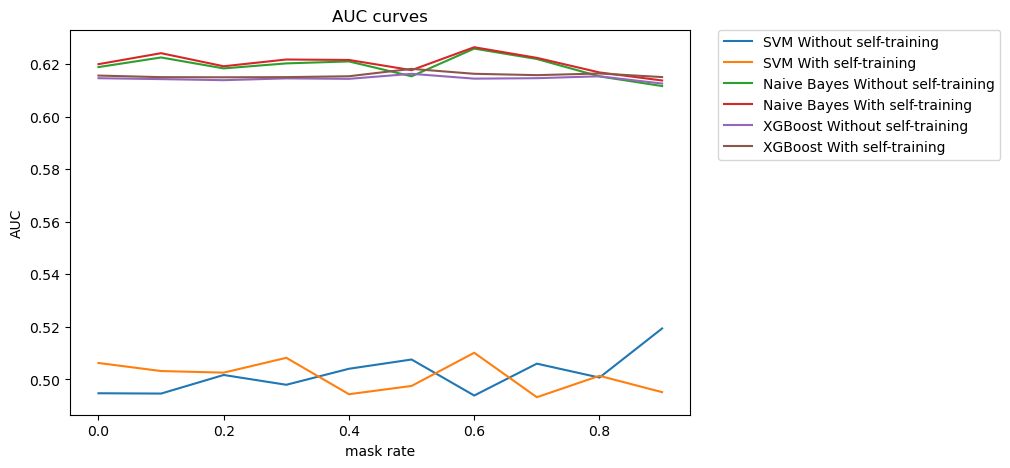

<Figure size 640x480 with 0 Axes>

In [14]:

maskrates = []
for i in range(0,10):
    maskrates.append(i/10)

f = plt.figure(num = 3, figsize=(8, 5))
plt.plot(maskrates, svcAUC_before, label="SVM Without self-training")
plt.plot(maskrates, svcAUC_after, label="SVM With self-training")
plt.plot(maskrates, nbAUC_before, label="Naive Bayes Without self-training")
plt.plot(maskrates, nbAUC_after, label="Naive Bayes With self-training")
plt.plot(maskrates, xgbAUC_before, label="XGBoost Without self-training")
plt.plot(maskrates, xgbAUC_after, label="XGBoost With self-training")
plt.xlabel("mask rate")
plt.ylabel("AUC")
plt.title("AUC curves")
plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right', borderaxespad=0)
plt.show()
plt.draw()
f.savefig("#inflatie-matrix.pdf",bbox_inches = 'tight')

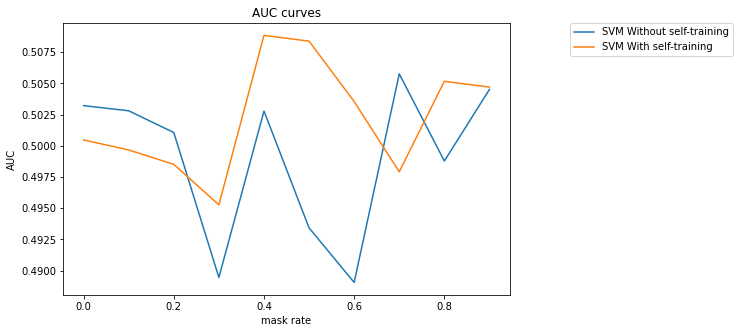

In [27]:
plt.figure(figsize=(8, 5))
plt.plot(maskrates, svcAUC_before, label="SVM Without self-training")
plt.plot(maskrates, svcAUC_after, label="SVM With self-training")
plt.xlabel("mask rate")
plt.ylabel("AUC")
plt.title("AUC curves")
plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right', borderaxespad=0)

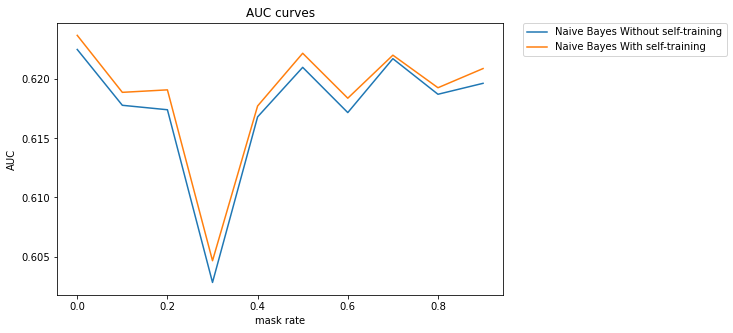

In [28]:
plt.figure(figsize=(8, 5))
plt.plot(maskrates, nbAUC_before, label="Naive Bayes Without self-training")
plt.plot(maskrates, nbAUC_after, label="Naive Bayes With self-training")
plt.xlabel("mask rate")
plt.ylabel("AUC")
plt.title("AUC curves")
plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right', borderaxespad=0)

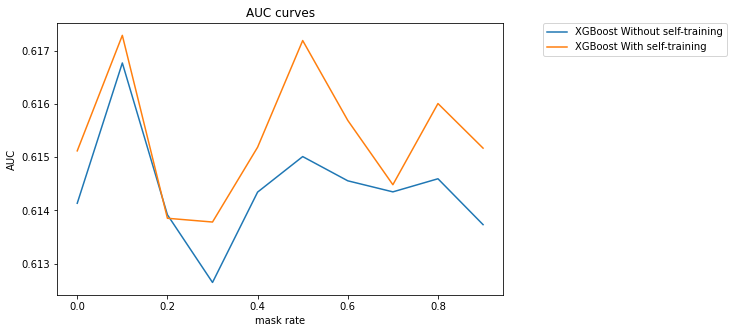

In [29]:
plt.figure(figsize=(8, 5))
plt.plot(maskrates, xgbAUC_before, label="XGBoost Without self-training")
plt.plot(maskrates, xgbAUC_after, label="XGBoost With self-training")
plt.xlabel("mask rate")
plt.ylabel("AUC")
plt.title("AUC curves")
plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right', borderaxespad=0)